In [37]:
import SimpleITK as sitk
import numpy as np
import os
import pandas as pd
import scipy.ndimage
from skimage.segmentation import clear_border

In [38]:
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, merge
from keras.layers import Convolution3D, Convolution2D, MaxPooling3D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.utils import np_utils
from keras import backend as K

In [40]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [41]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

In [58]:
'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        image_mask[int(coords[0]),int(coords[1]),int(coords[2])] = int(1)
                        #image_mask[np.round(coords[0]),np.round(coords[1]),np.round(coords[2])] = int(1)

    return image_mask

In [43]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [44]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

In [45]:
'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, cands, imageName):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img)
    lung_img = lung_img - 1024

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape	
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = np.round(offset/2)
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]
    
    path = '/Users/anthonypamart/Documents/SIR/Projets/CEI/Taff 15 mars/Images/' 
    # save images.    
    np.save(path + imageName + '_lung_img.npz', lung_img_512)
    np.save(path + imageName + '_lung_mask.npz', lung_mask_512)
    np.save(path + imageName + '_nodule_mask.npz', nodule_mask_512)
    
    return lung_img_512, lung_mask_512, nodule_mask_512, lung_img, lung_mask, nodule_mask

In [46]:
np.max(nodule_mask_512)

1.0

In [47]:
path = '/Users/anthonypamart/Documents/SIR/Projets/CEI/Taff 15 mars/subset0'
images = os.listdir(path)

##On ne garde que les images en .mhd
images_mhd = [] 
for i in range(0,len(images)):
    if images[i][-4:] == '.mhd':
        images_mhd.append(images[i])
        
##Liste des path de toutes les images
images_path = []
for i in range(0, len(images_mhd)):
    images_path.append(os.path.join(path, images_mhd[i]))

first_image_path = images_path[0]

In [48]:
##annotations.csv contient l'id, x, y, z et le diametre des nodules malades
cands = pd.read_csv('/Users/anthonypamart/Documents/SIR/Projets/CEI/Taff 15 mars/CSVFILES/annotations.csv')

##labels.csv contient l'id, x, y, z et si le nodules est malade ou non
labels = pd.read_csv('/Users/anthonypamart/Documents/SIR/Projets/CEI/Taff 15 mars/CSVFILES/candidates.csv')

##Liste des cands pour chaque image
cands_list = []
for i in range(0,len(images_mhd)):
    cands_list.append(cands[cands['seriesuid'] == images_mhd[i][0:-4]])

first_cands = cands_list[0]

In [49]:
first_img, origin, spacing = load_itk(first_image_path)

In [59]:
img_mask = draw_circles(first_img, first_cands, origin, spacing)

In [51]:
%%time
lung_img_512, lung_mask_512, nodule_mask_512, lung_img, lung_mask, nodule_mask = create_nodule_mask(first_image_path, first_cands, images_mhd[0][0:-4])

CPU times: user 45 s, sys: 5.39 s, total: 50.4 s
Wall time: 53.3 s


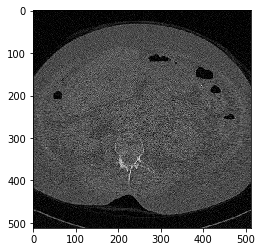

In [52]:
plt.imshow(first_img[0], cmap=plt.cm.gray)
plt.show()

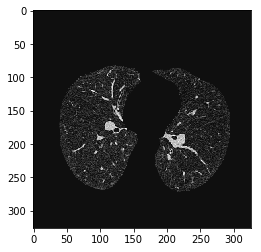

In [67]:
plt.imshow(lung_img[200], cmap=plt.cm.gray)
plt.show()

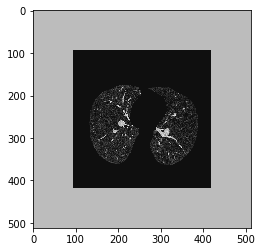

In [68]:
plt.imshow(lung_img_512[200], cmap=plt.cm.gray)
plt.show()

In [81]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [57]:
import os 
import numpy as np
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

#Note : 
- Rajouter plus de dropout ?
- Si ça marche, faire une fonction voir une classe
- Chercher à quoi sert model_checkpoint
- https://github.com/zhixuhao/unet/blob/master/unet.py#L90
- https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

In [109]:
inputs = Input((512,512,1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
print("conv1.shape : ", conv1.shape)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])


('conv1.shape : ', TensorShape([Dimension(None), Dimension(512), Dimension(512), Dimension(32)]))


In [110]:
imgs_train = np.reshape(lung_img_512, (lung_img_512.shape[0], lung_img_512.shape[1], lung_img_512.shape[2], 1))

imgs_mask_train = np.reshape(nodule_mask_512, (nodule_mask_512.shape[0], nodule_mask_512.shape[1], nodule_mask_512.shape[2], 1))
#imgs_test = 


#model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

#model.fit(imgs_train, imgs_mask_train, batch_size=4, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
model.fit(imgs_train, imgs_mask_train, batch_size=4, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True)

#imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
#np.save('../results/imgs_mask_test.npy', imgs_mask_test)

/Users/anthonypamart/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 292 samples, validate on 74 samples
Epoch 1/10


KeyboardInterrupt: 